In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature
from tqdm import tqdm
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

def load_point_colors_from_pcd(num_points, path):
    plydata = PlyData.read(path)

    features_dc = np.zeros((num_points, 3))
    features_dc[:, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
    features_dc[:, 1] = np.asarray(plydata.elements[0]["f_dc_1"])
    features_dc[:, 2] = np.asarray(plydata.elements[0]["f_dc_2"])

    colors = SH2RGB(features_dc)

    # N, 3
    return torch.clamp(torch.from_numpy(colors).squeeze().cuda(), 0.0, 1.0) * 255.



/home/cenjiazhong/.conda/envs/laga/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Setting and Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32
SCALE_AWARE_DIM = 24


scale_aware_dim = SCALE_AWARE_DIM
fixed_scale_gate = torch.tensor([[1 for j in range(32 - scale_aware_dim + i)] + [0 for k in range(scale_aware_dim - i)] for i in range(scale_aware_dim+1)]).cuda()
    
DATA_ROOT = './data/nerf_llff_data_for_3dgs/'
# MODEL_PATH = './output/3dovs-bed/'

MODEL_PATH = '../saga2/output/lerfovs-figurines-mini/' # 31000
# MODEL_PATH = './output/scannet-scene0000_00_og/' # 30000
# MODEL_PATH = './output/scannet-scene0645_00/' # 30000
# MODEL_PATH = './output/3dovs-room/' # 30000
# MODEL_PATH = './output/360-room/' # 31000

NUM_LVL = 1 if ('scannet' in MODEL_PATH and 'og' in MODEL_PATH) or '3dovs' in MODEL_PATH else 3
FEATURE_GAUSSIAN_ITERATION = 31000

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

CLIP_PATH = '../sagav2/clip_ckpt/ViT-B-16-laion2b_s34b_b88k.bin'

MULTI_LVL_DIM = [16,8,8] if NUM_LVL == 3 else [32]

# Data and Model Preparation


In [3]:
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--segment", action="store_true")
parser.add_argument('--target', default='scene', const='scene', nargs='?', choices=['scene', 'seg', 'feature', 'coarse_seg_everything', 'contrastive_feature', 'xyz'])
parser.add_argument('--idx', default=0, type=int)
parser.add_argument('--precomputed_mask', default=None, type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)
dataset.need_features = True
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ../saga2/output/lerfovs-figurines-mini/cfg_args
Config file found: ../saga2/output/lerfovs-figurines-mini/cfg_args
Loading trained model at iteration 30000, 31000
Allow Camera Principle Point Shift: False
Reading camera 299/299
Loading Training Cameras
Loading Test Cameras


In [4]:
# Load pre-computed decomposition results and semantic descriptors
multi_lvl_cluster_features = torch.load(os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_cluster_features.pth'))
multi_lvl_cluster_feature_weights = torch.load(os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_cluster_feature_weights.pth'))

try:
    multi_lvl_cluster_feature_weights_only_direction = torch.load(os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_cluster_feature_weights_only_direction.pth'))
except:
    print("No direction-only weights found!")

multi_lvl_seg_scores = torch.load(os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_seg_scores.pth'))

# max num of semantic descriptors per object
num_per_cluster_features = 20

# Load Cameras

In [5]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")

There are 299 views in the dataset.


# 3D Scene Decomposition (Sec. 5.3)

In [7]:
from copy import deepcopy
MASK_SIZE_THRESH = 400

import hdbscan
with torch.no_grad():
    multi_lvl_prototypes = [[],[],[]]
    multi_lvl_mask_filter = [[],[],[]]

    for tview in tqdm(scene.getTrainCameras()):
        torch.cuda.empty_cache()

        view = deepcopy(tview)

        view.feature_height, view.feature_width = view.image_height, view.image_width

        bg_color = [0 for i in range(FEATURE_DIM)]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
        rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, multi_lvl_norm=True, multi_lvl_dim=MULTI_LVL_DIM, smooth_type = None)['render']
        rendered_feature = rendered_feature.permute([1,2,0])
        sam_masks = view.original_masks.cuda()

        multi_lvl_masks_before_filt = []
        multi_lvl_masks = []

        sam_masks[sam_masks == -1] = -1000
        for lvl in range(1,NUM_LVL+1) if NUM_LVL > 1 else [0]:
            tmp_masks = sam_masks[lvl].clone()

            # for garden, disable it in other scenes (Low resolution for reducing GPU memory consumption)
            # tmp_masks = torch.nn.functional.interpolate(tmp_masks.unsqueeze(0).unsqueeze(0), (tmp_masks.shape[-2] //2,tmp_masks.shape[-1] //2), mode='nearest').squeeze()
        
            smallest_index = sam_masks[lvl-1].int().max()+1 if lvl > 0 else 0 
            tmp_masks -= smallest_index-1
            tmp_masks[tmp_masks < 0] = 0

            tmp_lvl_masks = torch.nn.functional.one_hot(tmp_masks.long(), num_classes=tmp_masks.max().int().item()+1)[:,:,1:].float()

            multi_lvl_masks_before_filt.append(tmp_lvl_masks)
        
        for lvl in range(NUM_LVL):
            tmp_mask = multi_lvl_masks_before_filt[lvl]

            mask_non_zero_count = tmp_mask.sum(dim = (0,1))

            # remove some extremely small masks which may have ambiguous semantic meaning
            fi = mask_non_zero_count > MASK_SIZE_THRESH

            tmp_mask = tmp_mask[:,:,fi]

            multi_lvl_masks.append(tmp_mask)

            multi_lvl_mask_filter[lvl].append(fi)
            
        normed_rendered_feature = []
        pre_dim = 0
        for dim in MULTI_LVL_DIM:
            normed_rendered_feature.append(torch.nn.functional.normalize(rendered_feature[:,:,pre_dim:pre_dim+dim], dim = -1))
            pre_dim += dim
        normed_rendered_feature = torch.cat(normed_rendered_feature, dim = -1)

        pre_dim = 0
        multi_lvl_features = []
        for i in range(NUM_LVL):
            multi_lvl_features.insert(0, torch.nn.functional.normalize(normed_rendered_feature[:,:,:MULTI_LVL_DIM[i]+pre_dim], dim = -1))
            pre_dim += MULTI_LVL_DIM[i]


        for lvl in range(NUM_LVL):
            if multi_lvl_features[lvl].shape[:2] != multi_lvl_masks[lvl].shape[:2]:
                multi_lvl_features[lvl] = torch.nn.functional.interpolate(multi_lvl_features[lvl].permute([2,0,1]).unsqueeze(0), multi_lvl_masks[lvl].shape[:2], mode = 'bilinear').squeeze(0).permute([1,2,0])
            
            multi_lvl_prototypes[lvl].append(
                torch.nn.functional.normalize(torch.einsum('hwc,hwf->fc', multi_lvl_features[lvl], multi_lvl_masks[lvl]), dim=-1, p=2)
            )

    multi_lvl_prototypes = [torch.cat(multi_lvl_prototypes[lvl], 0) for lvl in range(NUM_LVL)]
    multi_lvl_mask_filter = [torch.cat(multi_lvl_mask_filter[lvl], 0) for lvl in range(NUM_LVL)]

    multi_lvl_cluster_centers = []
    multi_lvl_cluster_labels = []
    for lvl in range(NUM_LVL):

        clusterer = hdbscan.HDBSCAN(min_cluster_size=5, cluster_selection_epsilon = 0.1 * (lvl+1))

        cluster_labels = clusterer.fit_predict(multi_lvl_prototypes[lvl].detach().cpu().numpy())
        print(np.unique(cluster_labels))

        existing_center = 0

        cluster_centers = torch.zeros(len(np.unique(cluster_labels[cluster_labels != -1])), multi_lvl_prototypes[lvl].shape[-1]).cuda()
        
        for i in np.unique(cluster_labels):
            if i == -1:
                continue

            cluster_centers[i] = torch.nn.functional.normalize(multi_lvl_prototypes[lvl][cluster_labels == i].mean(dim = 0), dim = -1)

        multi_lvl_cluster_centers.append(cluster_centers)
        multi_lvl_cluster_labels.append(cluster_labels)

  0%|          | 0/299 [00:00<?, ?it/s]

100%|██████████| 299/299 [00:10<00:00, 28.47it/s]


[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214
 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232
 233 234 235 236 237 238 239 240 241 242 243 244 24

In [9]:
# Use multi-level cluster centroids to compute segmentation scores

with torch.no_grad():

    point_features = feature_gaussians.get_point_features

    normed_point_features = []
    pre_dim = 0
    for dim in MULTI_LVL_DIM:
        normed_point_features.append(torch.nn.functional.normalize(point_features[:,pre_dim:pre_dim+dim], dim = -1))
        pre_dim += dim
    normed_point_features = torch.cat(normed_point_features, dim = -1)
    

    pre_dim = 0
    multi_lvl_point_features = []
    for i in range(NUM_LVL):
        multi_lvl_point_features.insert(0, torch.nn.functional.normalize(normed_point_features[:,:MULTI_LVL_DIM[i]+pre_dim], dim = -1))
        pre_dim += MULTI_LVL_DIM[i]


    multi_lvl_seg_scores = []

    for lvl in range(NUM_LVL):
        selected_feature = multi_lvl_point_features[lvl]
        cluster_centers = multi_lvl_cluster_centers[lvl]

        seg_score = torch.einsum('nc,bc->bn', cluster_centers.cuda(), selected_feature.cuda())

        multi_lvl_seg_scores.append(seg_score)


In [10]:
# All semantic features extracted by CLIP
multi_lvl_flatten_features = []
with torch.no_grad():
    for lvl in range(NUM_LVL):
        flatten_features = []
        for view in scene.getTrainCameras():
            torch.cuda.empty_cache()
            f = view.original_features.view(-1, 512)

            lvl_to_mask_id = []
            lastone = -1
            # NUM_LVL == 1, scannet from opengaussian
            for i in range(0, 4) if NUM_LVL == 3 else range(0, 1):
                tm = view.original_masks[i]
                curone = tm.max().int().item()
                lvl_to_mask_id.append([lastone+1, curone])
                lastone = curone
            
            if NUM_LVL > 1:
                interval = lvl_to_mask_id[lvl + 1]
                f = f[interval[0]:interval[1]+1,:]
            flatten_features.append(f)

        multi_lvl_flatten_features.append(torch.cat(flatten_features, dim = 0))

In [11]:
# 3D object to 2D mask mapper. This step builds co-relation among 2D masks (CLIP semantics) for each 3D object
multi_lvl_cluster_to_masks = [[],[],[]]
for lvl in range(NUM_LVL):
    # multi_lvl_cluster_labels
    for clus in tqdm(np.unique(multi_lvl_cluster_labels[lvl])):
        if clus == -1:
            continue
        multi_lvl_cluster_to_masks[lvl].append(torch.tensor(multi_lvl_cluster_labels[lvl] == clus).cuda())

100%|██████████| 69/69 [00:00<00:00, 16511.12it/s]


# View-Aggreated Semantic Representation (Sec. 5.4)

In the following four sections (Dynamic K-means, Dynamic K-Means with in loop denoise, Naive K-Means, Average Pooling), you only need to choose one to run. In default, we use dynamic K-means. The other three are for comparison.

## Cross-View Descriptor Extraction: Dynamic K-Means

In [12]:
# K-Means with dynamic K selection

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from sklearn.exceptions import ConvergenceWarning

def dynamic_k_selection(clus_feats, min_clusters=1, max_clusters=20, eps=1e-6, n_init = 10, check_loss = False, sample_weight = None):

    clus_feats_np = clus_feats.detach().cpu().numpy()
    best_k = min_clusters
    best_score = -1
    best_centers = None
    
    for k in range(min_clusters, min(max_clusters, clus_feats.shape[0]) + 1):
            if k == 1:
                centers = clus_feats.mean(dim=0, keepdim=True)
                score = -1
                labels = np.zeros(clus_feats.shape[0])
            else:
                model = KMeans(n_clusters=k, n_init=n_init, random_state=42)
                with warnings.catch_warnings(record=True) as w:
                    warnings.simplefilter("always", ConvergenceWarning)
                    labels = model.fit_predict(clus_feats_np, sample_weight=sample_weight)
                    if -1 in labels:
                        print('exist -1')
                    if len(set(labels)) < k:
                        score = -1
                    else:
                        try:
                            score = silhouette_score(clus_feats_np, labels)
                        except:
                            score = -1
                centers = torch.tensor(model.cluster_centers_).cuda()
            
            if score > best_score:
                best_k = k
                best_score = score
                best_centers = centers
                best_labels = labels

    if check_loss:
        return best_k, best_centers, best_score, (clus_feats * torch.nn.functional.normalize(best_centers[best_labels], dim = -1, p = 2)).sum(-1).mean()
    
    return best_k, best_centers, best_score, None


# K-MEANS for cluster features
from sklearn.cluster import KMeans
import warnings
from sklearn.exceptions import ConvergenceWarning

with torch.no_grad():
    multi_lvl_cluster_features = []
    multi_lvl_cluster_feature_weights = []
    multi_lvl_cluster_feature_weights_only_direction = []

    for lvl in range(NUM_LVL):
        tmp_lvl_cluster_labels = multi_lvl_cluster_labels[lvl]
        tmp_lvl_cluster_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]
        print(len(tmp_lvl_cluster_labels), tmp_lvl_cluster_features.shape)

    num_per_cluster_features = 20
    for lvl in range(0,NUM_LVL):
        cluster_to_masks = multi_lvl_cluster_to_masks[lvl]
        flatten_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]

        cluster_feature_loss = []
        cluster_features = []
        cluster_weights = []
        cluster_weights_only_direction = []
        for clus in tqdm(cluster_to_masks):

            if clus.nonzero().shape[0] == 0:
                cluster_features.append(torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda())
                cluster_weights.append(torch.zeros(num_per_cluster_features).cuda())
            else:
                clus_feats = torch.nn.functional.normalize(flatten_features[clus.nonzero()].squeeze(1), dim = -1, p = 2).cuda()
                avg_clus_feats = clus_feats.mean(dim = 0)
                avg_clus_feats = torch.nn.functional.normalize(avg_clus_feats, dim = -1, p = 2)

                best_k, cluster_centers, best_score, cl = dynamic_k_selection(clus_feats, max_clusters=min(clus_feats.shape[0], num_per_cluster_features), check_loss=True, sample_weight = None, n_init = 10)

                num_centers = len(cluster_centers)

                tmp_features = torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda()
                tmp_features[:num_centers] = cluster_centers[:num_centers]

                tmp_weights = torch.zeros(num_per_cluster_features).cuda()
                tmp_weights_only_direction = torch.zeros(num_per_cluster_features).cuda()

                t = torch.einsum('c,nc->n', avg_clus_feats.cuda(), tmp_features[:num_centers])

                # In case you want to disable the internal compactness term of the weighted descriptor relevance aggregation (DW^c, see Table 4 and Sec. 6.4).
                t2 = torch.einsum('c,nc->n', avg_clus_feats.cuda(), torch.nn.functional.normalize(tmp_features[:num_centers], dim = -1, p = 2))

                tmp_weights[:num_centers] = t
                tmp_weights_only_direction[:num_centers] = t2


                cluster_features.append(tmp_features)
                cluster_weights.append(tmp_weights)
                cluster_weights_only_direction.append(tmp_weights_only_direction)



        # Num_clusters * num_per_cluster_features, 512
        cluster_features = torch.cat(cluster_features, 0)
        cluster_weights = torch.cat(cluster_weights, 0)
        cluster_weights_only_direction = torch.cat(cluster_weights_only_direction, 0)

        multi_lvl_cluster_features.append(cluster_features)
        multi_lvl_cluster_feature_weights.append(cluster_weights)
        multi_lvl_cluster_feature_weights_only_direction.append(cluster_weights_only_direction)



26005 torch.Size([26005, 512])
13485 torch.Size([13485, 512])
6684 torch.Size([6684, 512])


100%|██████████| 68/68 [01:02<00:00,  1.09it/s]


## Cross-View Descriptor Extraction: Dynamic K-Means with in loop denoise

This is an experimental version not mentioned in the paper. In this version, we remove some noisy outliers during the K-means.

In [ ]:
# K-Means with dynamic K selection

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
from sklearn.exceptions import ConvergenceWarning

def dynamic_k_selection(clus_feats, min_clusters=1, max_clusters=20, eps=1e-6, n_init = 10):

    clus_feats_np = clus_feats.detach().cpu().numpy()
    best_k = min_clusters
    best_score = -1
    best_centers = None
    
    for k in range(min_clusters, min(max_clusters, clus_feats.shape[0]) + 1):
            if k == 1:
                centers = clus_feats.mean(dim=0, keepdim=True)
                score = -1
                labels = np.zeros(clus_feats.shape[0])
            else:
                model = KMeans(n_clusters=k, n_init=n_init, random_state=42)
                with warnings.catch_warnings(record=True) as w:
                    warnings.simplefilter("always", ConvergenceWarning)
                    labels = model.fit_predict(clus_feats_np)
                    if -1 in labels:
                        print('exist -1')
                    if len(set(labels)) < k:
                        score = -1
                    else:
                        try:
                            score = silhouette_score(clus_feats_np, labels)
                        except:
                            score = -1
                centers = torch.tensor(model.cluster_centers_).cuda()
            
            if score > best_score:
                best_k = k
                best_score = score
                best_centers = centers
                best_labels = labels

    return best_k, best_centers, best_score, (clus_feats * torch.nn.functional.normalize(best_centers[best_labels], dim = -1, p = 2)).sum(-1)


# K-MEANS for cluster features
from sklearn.cluster import KMeans
import warnings
from sklearn.exceptions import ConvergenceWarning

with torch.no_grad():
    multi_lvl_cluster_feature_loss_dynamic_kmeans = []
    multi_lvl_cluster_features = []
    multi_lvl_cluster_feature_weights = []
    multi_lvl_cluster_feature_weights_only_direction = []

    for lvl in range(NUM_LVL):
        tmp_lvl_cluster_labels = multi_lvl_cluster_labels[lvl]
        tmp_lvl_cluster_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]
        print(len(tmp_lvl_cluster_labels), tmp_lvl_cluster_features.shape)

    num_per_cluster_features = 20
    for lvl in range(0,NUM_LVL):
        cluster_to_masks = multi_lvl_cluster_to_masks[lvl]
        flatten_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]

        cluster_features = []
        cluster_weights = []
        cluster_weights_only_direction = []
        for clus in tqdm(cluster_to_masks):

            if clus.nonzero().shape[0] == 0:
                cluster_features.append(torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda())
                cluster_weights.append(torch.zeros(num_per_cluster_features).cuda())
            else:
                clus_feats = torch.nn.functional.normalize(flatten_features[clus.nonzero()].squeeze(1), dim = -1, p = 2).cuda()
                avg_clus_feats = clus_feats.mean(dim = 0)
                avg_clus_feats = torch.nn.functional.normalize(avg_clus_feats, dim = -1, p = 2)

                available_clus_feat_mask = torch.ones(clus_feats.shape[0]).cuda()

                # remove noise
                while True:
                    in_clus_feats = clus_feats[available_clus_feat_mask == 1]
                    best_k, cluster_centers, best_score, clus_feature_similarities = dynamic_k_selection(in_clus_feats, max_clusters=min(in_clus_feats.shape[0], num_per_cluster_features), n_init = 10)
                    if torch.all(clus_feature_similarities > 0.7):
                        break
                    else:
                        available_clus_feat_mask[available_clus_feat_mask == 1] = (clus_feature_similarities > 0.7).float()

                num_centers = len(cluster_centers)

                tmp_features = torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda()
                tmp_features[:num_centers] = cluster_centers[:num_centers]

                tmp_weights = torch.zeros(num_per_cluster_features).cuda()
                tmp_weights_only_direction = torch.zeros(num_per_cluster_features).cuda()

                t = torch.einsum('c,nc->n', avg_clus_feats.cuda(), tmp_features[:num_centers])
                t2 = torch.einsum('c,nc->n', avg_clus_feats.cuda(), torch.nn.functional.normalize(tmp_features[:num_centers], dim = -1, p = 2))

                tmp_weights[:num_centers] = t
                tmp_weights_only_direction[:num_centers] = t2


                cluster_features.append(tmp_features)
                cluster_weights.append(tmp_weights)
                cluster_weights_only_direction.append(tmp_weights_only_direction)

        # Num_clusters * num_per_cluster_features, 512
        cluster_features = torch.cat(cluster_features, 0)
        cluster_weights = torch.cat(cluster_weights, 0)
        cluster_weights_only_direction = torch.cat(cluster_weights_only_direction, 0)

        multi_lvl_cluster_features.append(cluster_features)
        multi_lvl_cluster_feature_weights.append(cluster_weights)
        multi_lvl_cluster_feature_weights_only_direction.append(cluster_weights_only_direction)

10782 torch.Size([10782, 512])
8332 torch.Size([8332, 512])
2219 torch.Size([2219, 512])


100%|██████████| 70/70 [00:54<00:00,  1.29it/s]


## Cross-View Descriptor Extraction: Naive K-Means

In [ ]:
# K-MEANS for cluster features
from sklearn.cluster import KMeans
import warnings
from sklearn.exceptions import ConvergenceWarning

with torch.no_grad():
    multi_lvl_cluster_features = []
    multi_lvl_cluster_feature_weights = []

    for lvl in range(NUM_LVL):
        tmp_lvl_cluster_labels = multi_lvl_cluster_labels[lvl]
        tmp_lvl_cluster_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]
        print(len(tmp_lvl_cluster_labels), tmp_lvl_cluster_features.shape)

    num_per_cluster_features = 20
    for lvl in range(0,NUM_LVL):
        cluster_to_masks = multi_lvl_cluster_to_masks[lvl]
        flatten_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]

        cluster_features = []
        cluster_weights = []
        for clus in tqdm(cluster_to_masks):

            if clus.nonzero().shape[0] == 0:
                cluster_features.append(torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda())
                cluster_weights.append(torch.zeros(num_per_cluster_features).cuda())
            else:
                clus_feats = torch.nn.functional.normalize(flatten_features[clus.nonzero()].squeeze(1), dim = -1, p = 2).cuda()
                avg_clus_feats = clus_feats.mean(dim = 0)
                avg_clus_feats = torch.nn.functional.normalize(avg_clus_feats, dim = -1, p = 2)

                if clus_feats.shape[0] > num_per_cluster_features:
                    model = KMeans(n_clusters=num_per_cluster_features)

                    with warnings.catch_warnings(record=True) as w:
                        warnings.simplefilter("always", ConvergenceWarning)
        
                        labels = model.fit_predict(clus_feats.detach().cpu().numpy())
                        cluster_centers = torch.tensor(model.cluster_centers_).cuda()

                        rep_center = False
                        for warning in w:
                            rep_center = rep_center or issubclass(warning.category, ConvergenceWarning)
                            if rep_center: break
                        
                        if rep_center:
                            similarity_matrix = cluster_centers @ cluster_centers.T

                            threshold = 0.999
                            duplicates = (similarity_matrix > threshold).float().triu(diagonal=1)
                            duplicate_indices = torch.nonzero(duplicates, as_tuple=False)
                            for idx in duplicate_indices:
                                duplicate_center = idx[1].item()
                                cluster_centers[duplicate_center] = torch.rand(flatten_features.shape[-1], device='cuda')

                    num_centers = len(cluster_centers)
                    tmp_features = torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda()
                    tmp_features[:num_centers] = cluster_centers[:num_centers]

                    tmp_weights = torch.zeros(num_per_cluster_features).cuda()
                    t = torch.einsum('c,nc->n', avg_clus_feats.cuda(), tmp_features[:num_centers])

                    tmp_weights[:num_centers] = t

                    cluster_features.append(tmp_features)
                    cluster_weights.append(tmp_weights)
                else:
                    tmp_features = torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda()
                    tmp_features[:len(clus_feats)] = clus_feats

                    tmp_weights = torch.zeros(num_per_cluster_features).cuda()
                
                    t = torch.einsum('c,nc->n', avg_clus_feats.cuda(), clus_feats)

                    tmp_weights[:len(clus_feats)] = t

                    cluster_features.append(tmp_features)
                    cluster_weights.append(tmp_weights)
                
        # Num_clusters * 10, 512
        cluster_features = torch.cat(cluster_features, 0)
        cluster_weights = torch.cat(cluster_weights, 0)

        cluster_features = torch.nn.functional.normalize(cluster_features, dim=-1, p=2)
        multi_lvl_cluster_features.append(cluster_features)
        multi_lvl_cluster_feature_weights.append(cluster_weights)


11210 torch.Size([11210, 512])
7139 torch.Size([7139, 512])
3810 torch.Size([3810, 512])


100%|██████████| 97/97 [00:03<00:00, 25.53it/s]


## Cross-View Descriptor Extraction: Average Pooling

In [ ]:
# Directly use average feature as a cluster center
multi_lvl_cluster_features = []
multi_lvl_cluster_feature_weights = []

for lvl in range(3):
    tmp_lvl_cluster_labels = multi_lvl_cluster_labels[lvl]
    tmp_lvl_cluster_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]
    print(len(tmp_lvl_cluster_labels), tmp_lvl_cluster_features.shape)

num_per_cluster_features = 1
for lvl in range(0,NUM_LVL):
    cluster_to_masks = multi_lvl_cluster_to_masks[lvl]
    flatten_features = multi_lvl_flatten_features[lvl][multi_lvl_mask_filter[lvl]]

    cluster_feature_loss = []
    retained_num = []
    cluster_features = []
    cluster_weights = []
    inner_cosine = []
    for clus in tqdm(cluster_to_masks):

        if clus.nonzero().shape[0] == 0:
            cluster_features.append(torch.rand(num_per_cluster_features, flatten_features.shape[-1]).cuda())
            cluster_weights.append(torch.zeros(num_per_cluster_features).cuda())
        else:
            clus_feats = torch.nn.functional.normalize(flatten_features[clus.nonzero()].squeeze(1), dim = -1, p = 2).cuda()
            avg_clus_feats = clus_feats.mean(dim = 0, keepdim=True)
            avg_clus_feats = torch.nn.functional.normalize(avg_clus_feats, dim = -1, p = 2)


            cluster_feature_loss.append((clus_feats * avg_clus_feats).sum(dim = -1).mean())

            num_features = clus_feats.shape[0]
            pos_features = (clus_feats * avg_clus_feats).sum(dim = -1) > 0.9
            retained_num.append(pos_features.sum().item() / num_features)

            cluster_features.append(avg_clus_feats)
            cluster_weights.append(torch.tensor([1.]).cuda())

            inner_cosine.append(torch.einsum('nc,kc->nk', clus_feats, clus_feats))

    cluster_features = torch.cat(cluster_features, 0)
    cluster_weights = torch.cat(cluster_weights, 0)
    
    cluster_features = torch.nn.functional.normalize(cluster_features, dim=-1, p=2)
    multi_lvl_cluster_features.append(cluster_features)
    multi_lvl_cluster_feature_weights.append(cluster_weights)


11210 torch.Size([11210, 512])
7139 torch.Size([7139, 512])
3810 torch.Size([3810, 512])


100%|██████████| 97/97 [00:00<00:00, 1604.46it/s]


In [ ]:
# Save the decomposition results and semantic descriptors

torch.save(multi_lvl_cluster_features, os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_cluster_features.pth'))
torch.save(multi_lvl_cluster_feature_weights, os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_cluster_feature_weights.pth'))
torch.save(multi_lvl_seg_scores, os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_seg_scores.pth'))
torch.save(multi_lvl_cluster_feature_weights_only_direction, os.path.join(os.path.dirname(FEATURE_PCD_PATH), 'multi_lvl_cluster_feature_weights_only_direction.pth'))

# Language-driven Segmentation

In [6]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_relevancy_cosine
from clip_utils.clip_utils import load_clip, OpenCLIPNetworkConfig

clip_config = OpenCLIPNetworkConfig()
clip_config.clip_model_pretrained = CLIP_PATH

clip_model = load_clip(clip_config)
clip_model.eval()
1

from pytorch3d.ops import knn_points

def bilateral_filter_with_color(points, scores, colors, K=16, neighbor_map = None, 
                                spatial_sigma=0.1, range_score_sigma=0.1, 
                                range_color_sigma=0.1):

    N, _ = points.shape

    if neighbor_map is None:
        knn = knn_points(points[None, ...], points[None, ...], K=K, return_nn=False)
        knn_idx = knn.idx[0]  # (N, K)
    else:
        knn_idx = neighbor_map

    neighbor_points = points[knn_idx]       # (N, K, 3)
    neighbor_scores = scores[knn_idx]       # (N, K)
    neighbor_colors = colors[knn_idx]       # (N, K, 3)

    points_expanded = points.unsqueeze(1).expand(-1, K, -1)   # (N, K, 3)
    scores_expanded = scores.unsqueeze(1).expand(-1, K)       # (N, K)
    colors_expanded = colors.unsqueeze(1).expand(-1, K, -1)   # (N, K, 3)

    spatial_distance = torch.norm(neighbor_points - points_expanded, dim=2)  # (N, K)

    spatial_weight = torch.exp(- (spatial_distance ** 2) / (2 * spatial_sigma ** 2))  # (N, K)

    score_difference = scores_expanded - neighbor_scores  # (N, K)

    range_score_weight = torch.exp(- (score_difference ** 2) / (2 * range_score_sigma ** 2))  # (N, K)

    color_difference = torch.norm(neighbor_colors - colors_expanded, dim=2)  # (N, K)

    range_color_weight = torch.exp(- (color_difference ** 2) / (2 * range_color_sigma ** 2))  # (N, K)

    range_weight = range_score_weight * range_color_weight  # (N, K)

    weights = spatial_weight * range_weight  # (N, K)

    weights_normalized = weights / (torch.sum(weights, dim=1, keepdim=True) + 1e-8)  # (N, K)

    filtered_scores = torch.sum(weights_normalized * neighbor_scores, dim=1)  # (N,)

    return filtered_scores
    

Embedding dimension 512


In [7]:
# Not all scene can apply this. Some scenes are too large.
postprocess = True

if postprocess:

    from utils.sh_utils import SH2RGB

    gaussian_colors = scene_gaussians._features_dc
    gaussian_colors = SH2RGB(gaussian_colors.squeeze())
    gaussian_colors = torch.clip(gaussian_colors, 0, 1)

    K = 16
    points = feature_gaussians.get_xyz
    knn = knn_points(points[None, ...], points[None, ...], K=K, return_nn=False)
    neighbor_map = knn.idx[0]  # (N, K)


In [8]:
# cluster FEATURE based code
prompt = "jake from the adventure time"
with torch.no_grad():

    point_colors = None
    stack_of_cosine = []

    multi_lvl_cluster_scores = []
    for lvl in range(0,NUM_LVL):

        cluster_features = multi_lvl_cluster_features[lvl]
        cluster_weights = multi_lvl_cluster_feature_weights[lvl].clone()
        seg_score = multi_lvl_seg_scores[lvl]
        rel, pos, neg = get_relevancy_cosine(clip_model, torch.nn.functional.normalize(cluster_features.cuda(), dim = -1, p = 2), prompt)
        cluster_scores = (rel * cluster_weights).reshape([-1, num_per_cluster_features])

        cluster_scores, index = cluster_scores.max(dim = 1)[0], cluster_scores.max(dim = 1)[1]

        multi_lvl_cluster_scores.append(cluster_scores)

        pos = pos.reshape([-1, num_per_cluster_features])
        batch_indices = torch.arange(pos.shape[0]).to(pos.device)  # [batch_size]

        selected_pos = pos[batch_indices, index]  # [batch_size]


        stack_of_cosine.append(selected_pos[seg_score.argmax(dim = -1).cpu().numpy()])


    for lvl in [0,1,2]:
        seg_score = multi_lvl_seg_scores[lvl]
        cluster_scores = multi_lvl_cluster_scores[lvl]

        cluster_colors = np.array(cluster_scores.cpu())

        cluster_colors[cluster_colors < 0] = 0

        cluster_colors = np.expand_dims(cluster_colors, axis=1)
        cur_lvl_point_colors = cluster_colors[seg_score.argmax(dim = -1).cpu().numpy()]
        point_colors = cur_lvl_point_colors if point_colors is None else point_colors + cur_lvl_point_colors
    
    stack_of_cosine = torch.stack(stack_of_cosine, 0)
    stack_of_cosine = stack_of_cosine.max(dim = 0)[0]

    point_colors /= NUM_LVL
    # remove too low scores before min-max normalization for stability
    point_colors = np.clip(point_colors, np.quantile(point_colors, 0.25), 1e9)
    point_colors = point_colors - point_colors.min()
    point_colors = point_colors / point_colors.max()
    point_colors[(stack_of_cosine < 0.23).cpu().numpy()] = 0

    point_colors[point_colors < 0.6] = 0
    point_colors[point_colors != 0] = 1

    if not postprocess:
        point_colors = point_colors.repeat(3, axis=1)
    else:
        point_colors = bilateral_filter_with_color(feature_gaussians.get_xyz, torch.from_numpy(point_colors).squeeze().cuda(), gaussian_colors, spatial_sigma=0.5, range_score_sigma = 500, range_color_sigma = 500, neighbor_map=neighbor_map)
        point_colors = point_colors.cpu().unsqueeze(-1).numpy().repeat(3, axis=1)


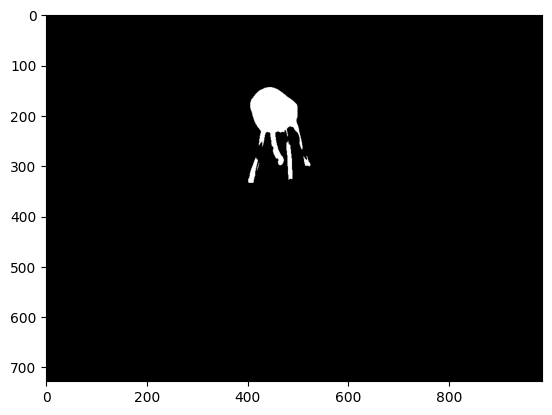

In [9]:
with torch.no_grad():
    background = torch.tensor([0,0,0], dtype=torch.float32, device="cuda")
    view = scene.getTrainCameras()[0]
    render_res = render(view, feature_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).float().cuda(), override_mask=torch.from_numpy(point_colors).float().cuda()[:,0:1])['render']
    fg = (render_res > 0.5).float().permute([1,2,0]).detach().cpu().numpy()
    plt.imshow(fg)


In [10]:
# segment or remove the target

scene_gaussians.roll_back()
# segment
p_mask = point_colors[:,0] > 0.5
# remove
# p_mask = point_colors[:,0] < 0.5
scene_gaussians.segment(torch.from_numpy(p_mask).cuda().bool())

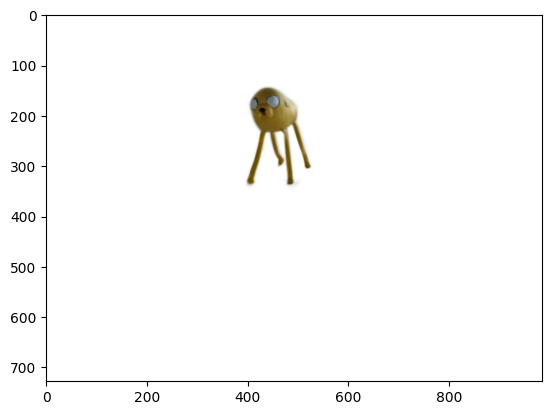

In [11]:
bg_color = [1 for i in range(3)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_image = render(cameras[0], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_image.permute([1,2,0]).detach().cpu().numpy())
scene_gaussians.roll_back()

# Evaluation

## Eval Lerf-OVS

In [ ]:
# Borrowed from LangSplat

import numpy as np
import torch
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
from pathlib import Path


def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='firebrick', marker='o',
               s=marker_size, edgecolor='black', linewidth=2.5, alpha=1)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='o',
               s=marker_size, edgecolor='black', linewidth=1.5, alpha=1)   


def show_box(boxes, ax, color=None):
    if type(color) == str and color == 'random':
        color = np.random.random(3)
    elif color is None:
        color = 'black'
    for box in boxes.reshape(-1, 4):
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=color, facecolor=(0,0,0,0), lw=4, 
                                   capstyle='round', joinstyle='round', linestyle='dotted')) 


def show_result(image, point, bbox, save_path):
    plt.figure()
    plt.imshow(image)
    rect = patches.Rectangle((0, 0), image.shape[1]-1, image.shape[0]-1, linewidth=0, edgecolor='none', facecolor='white', alpha=0.3)
    plt.gca().add_patch(rect)
    input_point = point.reshape(1,-1)
    input_label = np.array([1])
    show_points(input_point, input_label, plt.gca())
    show_box(bbox, plt.gca())
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=200)
    plt.close()


def smooth(mask):
    h, w = mask.shape[:2]
    im_smooth = mask.copy()
    scale = 3
    for i in range(h):
        for j in range(w):
            square = mask[max(0, i-scale) : min(i+scale+1, h-1),
                          max(0, j-scale) : min(j+scale+1, w-1)]
            im_smooth[i, j] = np.argmax(np.bincount(square.reshape(-1)))
    return im_smooth

def colormap_saving(image: torch.Tensor, save_path=None, colormap: str = "turbo", normalize: bool = True, colormap_min: float = -1.0, colormap_max: float = 1.0):
    """
    Apply a colormap to an image tensor and save the result.
    
    If the image's shape is (h, w, 1): draw a colored relevance map.
    If the image's shape is (h, w, 3): return it directly.
    If the image's shape is (h, w, c): execute PCA and transform it into (h, w, 3).
    """
    image_np = image.squeeze().detach().cpu().numpy()

    # Normalize the image if required
    if normalize:
        image_np = (image_np - colormap_min) / (colormap_max - colormap_min)
        image_np = np.clip(image_np, 0, 1)

    # Apply colormap
    cmap = plt.get_cmap(colormap)
    if image_np.ndim == 2 or (image_np.ndim == 3 and image_np.shape[-1] == 1):  # Single channel
        output_image = cmap(image_np)[..., :3]  # Apply colormap and remove alpha channel
    elif image_np.ndim == 3 and image_np.shape[-1] == 3:  # RGB image
        output_image = image_np  # Directly use the RGB image
    else:  # Multichannel image, reduce to 3 channels using PCA
        from sklearn.decomposition import PCA
        pca = PCA(n_components=3)
        image_flat = image_np.reshape(-1, image_np.shape[-1])
        image_pca = pca.fit_transform(image_flat).reshape(image_np.shape[0], image_np.shape[1], 3)
        output_image = (image_pca - np.min(image_pca)) / (np.max(image_pca) - np.min(image_pca))

    # Save the image if save_path is provided
    if save_path is not None:
        plt.imsave(save_path.with_suffix(".png"), output_image)
    
    return output_image

def vis_mask_save(mask, save_path: Path = None):
    mask_save = mask.copy()
    mask_save[mask == 1] = 255
    save_path.parent.mkdir(exist_ok=True, parents=True)
    cv2.imwrite(str(save_path), mask_save)


def polygon_to_mask(img_shape, points_list):
    points = np.asarray(points_list, dtype=np.int32)
    mask = np.zeros(img_shape, dtype=np.uint8)
    cv2.fillPoly(mask, [points], 1)
    return mask


def stack_mask(mask_base, mask_add):
    mask = mask_base.copy()
    mask[mask_add != 0] = 1
    return mask

import json
import os
import glob
from collections import defaultdict
from pathlib import Path
from typing import Dict, Union
import numpy as np

def eval_gt_lerfdata(json_folder: Union[str, Path] = None, ouput_path: Path = None):
    """
    Organize LERF's gt annotations.
    gt format:
        file name: frame_xxxxx.json
        file content: labelme format
    return:
        gt_ann: dict()
            keys: str(int(idx))
            values: dict()
                keys: str(label)
                values: dict() which contain 'bboxes' and 'mask'
        dimensions: tuple (height, width)
        img_paths: list of image file paths
        idx_list: list of indices
    """
    gt_json_paths = sorted(glob.glob(os.path.join(str(json_folder), 'frame_*.json')))
    img_paths = sorted(glob.glob(os.path.join(str(json_folder), 'frame_*.jpg')))
    gt_ann = {}
    idx_list = []
    
    for js_path in gt_json_paths:
        img_ann = defaultdict(dict)
        with open(js_path, 'r') as f:
            gt_data = json.load(f)
        
        h, w = gt_data['info']['height'], gt_data['info']['width']
        idx = int(gt_data['info']['name'].split('_')[-1].split('.jpg')[0]) - 1
        idx_list.append(idx)
        
        for prompt_data in gt_data["objects"]:
            label = prompt_data['category']
            box = np.asarray(prompt_data['bbox']).reshape(-1)           # x1y1x2y2
            mask = polygon_to_mask((h, w), prompt_data['segmentation'])
            if img_ann[label].get('mask', None) is not None:
                mask = stack_mask(img_ann[label]['mask'], mask)
                img_ann[label]['bboxes'] = np.concatenate(
                    [img_ann[label]['bboxes'].reshape(-1, 4), box.reshape(-1, 4)], axis=0)
            else:
                img_ann[label]['bboxes'] = box
            img_ann[label]['mask'] = mask
            
            # Save for visualization
            save_path = ouput_path / 'gt' / gt_data['info']['name'].split('.jpg')[0] / f'{label}.jpg'
            save_path.parent.mkdir(exist_ok=True, parents=True)
            vis_mask_save(mask, save_path)
        
        gt_ann[f'{idx}'] = img_ann

    return gt_ann, (h, w), img_paths, idx_list


In [13]:
import numpy as np
import cv2
import torch
from typing import Dict

def smooth(mask: np.ndarray, kernel_size: int = 5) -> np.ndarray:
    """Apply a smoothing filter to the mask."""
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size ** 2)
    smoothed_mask = cv2.filter2D(mask.astype(np.float32), -1, kernel)
    return np.clip(smoothed_mask, 0, 1).astype(np.uint8)

def activate_stream(valid_map: torch.Tensor,
                    image,
                    img_ann: Dict = None, 
                    thresh: float = 0.5,
                    image_name = None,
                    show_results = True):

    n_head, n_prompt, h, w = valid_map.shape
    n_head = 1 # ignore the 2th and 3th layers
    positives = list(img_ann.keys())

    chosen_iou_list, chosen_lvl_list = [], []

    for k in range(n_prompt):
        iou_lvl = np.zeros(n_head)
        mask_lvl = np.zeros((n_head, h, w))
        for i in range(n_head):
            
            output_path_relev = image_name / 'heatmap' / f'{positives[k]}_{i}.png'
            output_path_relev.parent.mkdir(exist_ok=True, parents=True)
            if show_results:
                colormap_saving(valid_map[i][k].unsqueeze(-1), output_path_relev)
            
            p_i = torch.clip(valid_map[i][k] - 0.5, 0, 1).unsqueeze(-1)
            p_i_normalized = p_i / (p_i.max() + 1e-6)
            cmap = plt.get_cmap("turbo")
            p_i_np = p_i_normalized.detach().cpu().numpy().squeeze()  # Remove single-dimensional entries
            cmap = plt.get_cmap("turbo")
            p_i_colored = cmap(p_i_np)[..., :3]
            valid_composited = torch.from_numpy(p_i_colored).to(p_i.device).float()

            mask = (valid_map[i][k] < 0.5).squeeze()
            valid_composited[mask, :] = image[mask, :] * 0.3
            output_path_compo = image_name / 'composited' / f'{positives[k]}_{i}'
            output_path_compo.parent.mkdir(exist_ok=True, parents=True)

            if show_results:
                colormap_saving(valid_composited, output_path_compo)
            
            # truncate the heatmap into mask
            output = valid_map[i][k]

            mask_pred = (output.detach().cpu().numpy() > thresh).astype(np.uint8)
            mask_pred = smooth(mask_pred)
            mask_lvl[i] = mask_pred
            mask_gt = img_ann[positives[k]]['mask'].astype(np.uint8)
            
            # calculate iou
            intersection = np.sum(np.logical_and(mask_gt, mask_pred))
            union = np.sum(np.logical_or(mask_gt, mask_pred))
            iou = np.sum(intersection) / np.sum(union)
            iou_lvl[i] = iou

        score_lvl = torch.zeros((n_head,), device=valid_map.device)
        for i in range(n_head):
            score = valid_map[i, k].max()
            score_lvl[i] = score
        chosen_lvl = torch.argmax(score_lvl)
        
        chosen_iou_list.append(iou_lvl[chosen_lvl])
        chosen_lvl_list.append(chosen_lvl.detach().cpu().numpy())
        
        # save for visualization
        save_path = image_name / f'chosen_{positives[k]}.png'
        if show_results:
            vis_mask_save(mask_lvl[chosen_lvl], save_path)

    return chosen_iou_list, chosen_lvl_list


## Eval on lerf_ovs

In [14]:
json_folder="data/lerf_ovs/label"
# "figurines, waldo_kitchen, teatime, ramen"
dataset_name="figurines"
json_folder = os.path.join(json_folder, dataset_name)
output_path = f"output/eval_contra_result/{dataset_name}"

# Since the rendered 'mask' of 3D-GS is continuous, we need to set a threshold to convert it into binary mask.
mask_thresh = 0.1

point_thresh = 0.6
cosine_thresh = 0.23


In [15]:
# Max Pooling
@torch.no_grad()
def cal_score_score_based(scene, clip_model, multi_lvl_cluster_to_masks, target_view, prompt = "frog cup"):
    multi_lvl_rel_score = [[],[],[]]
    with torch.no_grad():
        for view in scene.getTrainCameras():
            torch.cuda.empty_cache()
            f = view.original_features.view(-1, 512)
            f = torch.nn.functional.normalize(f.float(), dim = -1, p = 2)
            rel, pos, neg = get_relevancy_cosine(clip_model, f.cuda(), prompt)

            lvl_to_mask_id = []
            lastone = -1
            for i in range(0, 4):
                tm = view.original_masks[i]
                curone = tm.max().int().item()
                lvl_to_mask_id.append([lastone+1, curone])
                lastone = curone
            
            for lvl in range(3):
                interval = lvl_to_mask_id[lvl+1]
                tmp_rel = rel[interval[0]:interval[1]+1]
                
                multi_lvl_rel_score[lvl].append(tmp_rel)

    for lvl in range(3):
        multi_lvl_rel_score[lvl] = torch.cat(multi_lvl_rel_score[lvl], 0)


    point_colors = None

    for lvl in range(0,3):
        selected_lvl = lvl
        cluster_to_masks, rel_score = multi_lvl_cluster_to_masks[selected_lvl], multi_lvl_rel_score[selected_lvl][multi_lvl_mask_filter[lvl]]
        seg_score = multi_lvl_seg_scores[selected_lvl]

        cluster_to_masks = torch.stack(cluster_to_masks, 0)
        cluster_scores = (cluster_to_masks * rel_score.unsqueeze(0)).max(dim = -1)[0]


        cluster_colors = np.array(cluster_scores.cpu())

        cluster_colors = np.expand_dims(cluster_colors, axis=1)

        point_colors = cluster_colors[seg_score.argmax(dim = -1).cpu().numpy()] if point_colors is None else point_colors + cluster_colors[seg_score.argmax(dim = -1).cpu().numpy()]

    point_colors /= 3

    point_colors = np.clip(point_colors, np.quantile(point_colors, 0.25), 1e9)

    point_colors = (point_colors - point_colors.min()) / (point_colors.max() - point_colors.min())

    point_colors[point_colors < 0.6] = 0
    point_colors[point_colors != 0] = 1

    point_colors = bilateral_filter_with_color(feature_gaussians.get_xyz, torch.from_numpy(point_colors).squeeze().cuda(), gaussian_colors, spatial_sigma=0.5, range_score_sigma=0.5, range_color_sigma=0.5, neighbor_map=neighbor_map)

    point_colors = point_colors.cpu().unsqueeze(-1).numpy().repeat(3, axis=1)

    bg_color = [0 for i in range(3)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    render_res = render(target_view, scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).float().cuda())['render']
    return render_res


@torch.no_grad()
def cal_score_feature_based(clip_model, multi_lvl_cluster_features, multi_lvl_cluster_feature_weights, num_per_cluster_features, target_view, prompt = "frog cup", stratey = "mean", thresh = point_thresh, cosine_thresh=cosine_thresh, clip_quantile = 0.25, neighbor_map = None, selected_lvls = None):
    # point_colors = None
    point_colors = []
    stack_of_cosine = []
    for lvl in range(3) if selected_lvls is None else selected_lvls:
        cluster_features = multi_lvl_cluster_features[lvl]
        cluster_features_weights = multi_lvl_cluster_feature_weights[lvl].clone()

        # No reweighting (-DW)
        # cluster_features_weights[cluster_features_weights != 0] = 1

        # No Directional Consistency (+DW^C)
        # cluster_features_weights[cluster_features_weights != 0] = cluster_features[cluster_features_weights != 0, :].norm(dim = -1)

        seg_score = multi_lvl_seg_scores[lvl]
        rel, pos, neg = get_relevancy_cosine(clip_model, torch.nn.functional.normalize(cluster_features.cuda(), dim = -1, p = 2), prompt)
        # rel, pos, neg = get_relevancy_cosine(clip_model, cluster_features.cuda(), prompt)

        cluster_scores = (rel * cluster_features_weights).reshape([-1, num_per_cluster_features])

        cluster_scores, index = cluster_scores.max(dim = 1)[0], cluster_scores.max(dim = 1)[1]

        pos = pos.reshape([-1, num_per_cluster_features])
        batch_indices = torch.arange(pos.shape[0]).to(pos.device)  # [batch_size]
        selected_pos = pos[batch_indices, index]  # [batch_size]
        stack_of_cosine.append(selected_pos[seg_score.argmax(dim = -1).cpu().numpy()])


        cluster_colors = np.array(cluster_scores.cpu())

        cluster_colors[cluster_colors < 0] = 0
        # unsqueeze numpy array
        cluster_colors = np.expand_dims(cluster_colors, axis=1)
        
        cur_lvl_point_colors = cluster_colors[seg_score.argmax(dim = -1).cpu().numpy()]

        point_colors.append(cur_lvl_point_colors)

    if stratey == "max":
        max_score = -1
        max_idx = -1
        for idx, point_color in enumerate(point_colors):
            if point_color.max() > max_score:
                max_score = point_color.max()
                max_idx = idx
        point_colors = point_colors[max_idx]
        print(prompt, max_idx)
    else:
        point_colors = np.stack(point_colors, axis=0).mean(axis=0)
    
    stack_of_cosine = torch.stack(stack_of_cosine, 0)
    stack_of_cosine = stack_of_cosine.max(dim = 0)[0]
    cosine_filter = stack_of_cosine < cosine_thresh

    point_colors = np.clip(point_colors, np.quantile(point_colors, clip_quantile), 1e9)

    point_colors = (point_colors - point_colors.min()) / (point_colors.max() - point_colors.min())

    point_colors[cosine_filter.cpu().numpy()] = 0

    point_colors[point_colors < thresh] = 0
    point_colors[point_colors != 0] = 1

    point_colors = bilateral_filter_with_color(feature_gaussians.get_xyz, torch.from_numpy(point_colors).squeeze().cuda(), gaussian_colors, spatial_sigma=0.5, range_score_sigma=0.5, range_color_sigma=0.5, neighbor_map=neighbor_map)

    point_colors = point_colors.cpu().unsqueeze(-1).numpy().repeat(3, axis=1)

    bg_color = [0 for i in range(3)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    render_res = render(target_view, feature_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).float().cuda(), override_mask=torch.from_numpy(point_colors).float().cuda()[:,0:1])['render']

    return render_res


## EVAL LERF

In [16]:
import matplotlib.pyplot as plt

SHOW_RESULTS = False

new_iou_list = []
per_class_iou_sum = {}
per_class_iou_count = {}

gt_ann, image_shape, image_paths, idx_list = eval_gt_lerfdata(Path(json_folder), Path(output_path))
print(idx_list)
chosen_iou_all, chosen_lvl_list = [], []
acc_num = 0

with torch.no_grad():
    from utils.sh_utils import SH2RGB

    gaussian_colors = scene_gaussians._features_dc
    gaussian_colors = SH2RGB(gaussian_colors.squeeze())
    gaussian_colors = torch.clip(gaussian_colors, 0, 1)

    points_xyz = feature_gaussians.get_xyz
    N, _ = points_xyz.shape
    knn = knn_points(points_xyz[None, ...], points_xyz[None, ...], K=16, return_nn=False)
    neighbor_map = knn.idx[0]  # (N, K)


for j, idx in enumerate(idx_list):
    rendered_similarities_list = []
    idx_str = str(idx)
    item_key_list = list(gt_ann[idx_str].keys())
    img_ann = gt_ann[f'{idx}']
    
    for item_key in item_key_list:
        gt_mask = gt_ann[idx_str][item_key]['mask']
        gt_bbox = gt_ann[idx_str][item_key]['bboxes']
        torch.cuda.synchronize()

        # Rendering
        start = time.time()

        rendered_similarities = cal_score_feature_based(clip_model, multi_lvl_cluster_features, multi_lvl_cluster_feature_weights, num_per_cluster_features, cameras[idx], item_key, stratey='mean', neighbor_map=neighbor_map)

        # No internal compactness term
        # rendered_similarities = cal_score_feature_based(clip_model, multi_lvl_cluster_features, multi_lvl_cluster_feature_weights_only_direction, num_per_cluster_features, cameras[idx], item_key, stratey='mean', neighbor_map=neighbor_map)
        
        torch.cuda.synchronize()
        end = time.time()
        total_time = end - start

        rendered_similarities_list.append(rendered_similarities)

    rendered_similarities_stack = torch.stack(rendered_similarities_list, dim=1)

    first_rendered_similarity = rendered_similarities_stack[0]
    first_rendered_similarity_np = first_rendered_similarity.detach().cpu().numpy()
    
    image_name = Path(output_path) / f'{idx+1:0>5}'
    image_name.mkdir(exist_ok=True, parents=True)

    rgb_img = cv2.imread(image_paths[j])[..., ::-1]
    rgb_img = (rgb_img / 255.0).astype(np.float32)
    rgb_img = torch.from_numpy(rgb_img).to("cuda")
    # Evaluating
    c_iou_list, c_lvl = activate_stream(rendered_similarities_stack, rgb_img, img_ann, thresh=mask_thresh, image_name = image_name, show_results=SHOW_RESULTS)
    chosen_iou_all.extend(c_iou_list)
    chosen_lvl_list.extend(c_lvl)

    # keep 3 decimal places
    print_res = []
    for a,b in zip(item_key_list, c_iou_list):
        per_class_iou_sum[a] = per_class_iou_sum.get(a, 0) + b
        per_class_iou_count[a] = per_class_iou_count.get(a, 0) + 1
        if b > 0.5:
            print_res.append(f'{a}:{round(b, 3)}')
        else:
            print_res.append(f'\033[91m{a}:{round(b, 3)}\033[0m')
        
        if a != 'pikachu' and a != 'pumpkin':
            new_iou_list.append(b)
    print_res = ', '.join(print_res)

    print(print_res)

# iou
mean_iou = sum(chosen_iou_all) / len(chosen_iou_all)

print(f"Mean IoU: {mean_iou:.4f}")

[40, 104, 151, 194]
old camera:0.192, toy elephant:0.913, waldo:0.843, tesla door handle:0.594, porcelain hand:0.821, rubber duck with hat:0.473, rubber duck with buoy:0.454, pink ice cream:0.946, red toy chair:0.834, green apple:0.939, pikachu:0.224, red apple:0.208, spatula:0.83, jake:0.68, toy cat statue:0.625, pirate hat:0.827, miffy:0.912
rubics cube:0.829, green apple:0.95, green toy chair:0.86, jake:0.401, old camera:0.302, pink ice cream:0.896, pumpkin:0.0, red apple:0.625, rubber duck with hat:0.318, tesla door handle:0.388, spatula:0.752, rubber duck with buoy:0.574, pirate hat:0.154
rubber duck with hat:0.937, rubics cube:0.674, toy elephant:0.969, green apple:0.875, jake:0.557, toy cat statue:0.897, pikachu:0.251, porcelain hand:0.867, red apple:0.151, waldo:0.859, pirate hat:0.597
toy elephant:0.911, pink ice cream:0.949, porcelain hand:0.883, green apple:0.911, green toy chair:0.972, old camera:0.113, rubics cube:0.901, spatula:0.812, toy cat statue:0.617, waldo:0.837, ru

# Eval Scannet

In [ ]:
nyu40_dict = {
    0: "unlabeled", 1: "wall", 2: "floor", 3: "cabinet", 4: "bed", 5: "chair",
    6: "sofa", 7: "table", 8: "door", 9: "window", 10: "bookshelf",
    11: "picture", 12: "counter", 13: "blinds", 14: "desk", 15: "shelves",
    16: "curtain", 17: "dresser", 18: "pillow", 19: "mirror", 20: "floormat",
    21: "clothes", 22: "ceiling", 23: "books", 24: "refrigerator", 25: "television",
    26: "paper", 27: "towel", 28: "showercurtain", 29: "box", 30: "whiteboard",
    31: "person", 32: "nightstand", 33: "toilet", 34: "sink", 35: "lamp",
    36: "bathtub", 37: "bag", 38: "otherstructure", 39: "otherfurniture", 40: "otherprop"
}

# ScanNet 20 classes
scannet19_dict = {
    1: "wall", 2: "floor", 3: "cabinet", 4: "bed", 5: "chair",
    6: "sofa", 7: "table", 8: "door", 9: "window", 10: "bookshelf",
    11: "picture", 12: "counter", 14: "desk", 16: "curtain",
    24: "refrigerator", 28: "shower curtain", 33: "toilet", 34: "sink",
    36: "bathtub", # 39: "otherfurniture"
}

def create_cityscapes_label_colormap(show_classid = -1):
    """Creates a label colormap used in CITYSCAPES segmentation benchmark.

    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=np.uint8)

    if show_classid < 0:
        colormap[0] = [0, 0, 0]
        colormap[1] = [244, 35, 232]
        colormap[2] = [70, 70, 70]
        colormap[3] = [102, 102, 156]
        colormap[4] = [190, 153, 153]
        colormap[5] = [153, 153, 153]
        colormap[6] = [250, 170, 30]
        colormap[7] = [220, 220, 0]
        colormap[8] = [107, 142, 35]
        colormap[9] = [152, 251, 152]
        colormap[10] = [70, 130, 180]
        colormap[11] = [220, 20, 60]
        colormap[12] = [255, 0, 0]
        colormap[13] = [0, 0, 142]
        colormap[14] = [0, 0, 70]
        colormap[15] = [0, 60, 100]
        colormap[16] = [0, 80, 100]
        colormap[17] = [0, 0, 230]
        colormap[18] = [119, 11, 32]
    else:
        colormap[show_classid] = [255, 0, 0]
    return colormap


def read_labels_from_ply(file_path):
    ply_data = PlyData.read(file_path)
    vertex_data = ply_data['vertex'].data
    # Extract the coordinates and labels of the points. The labels are from 1 to 40 for the NYU40 dataset, with 0 being invalid.
    points = np.vstack([vertex_data['x'], vertex_data['y'], vertex_data['z']]).T
    labels = vertex_data['label']
    return points, labels

def calculate_metrics(gt, pred, total_classes):
    gt = gt.cpu()
    pred = pred.cpu()
    pred[gt == 0] = 0

    ious = torch.zeros(total_classes)

    intersection = torch.zeros(total_classes)
    union = torch.zeros(total_classes)
    correct = torch.zeros(total_classes)
    total = torch.zeros(total_classes)

    for cls in range(1, total_classes):
        intersection[cls] = torch.sum((gt == cls) & (pred == cls)).item()
        union[cls] = torch.sum((gt == cls) | (pred == cls)).item()
        correct[cls] = torch.sum((gt == cls) & (pred == cls)).item()
        total[cls] = torch.sum(gt == cls).item()

    valid_union = union != 0
    ious[valid_union] = intersection[valid_union] / union[valid_union]

    # Only consider the categories that exist in the current scene
    gt_classes = torch.unique(gt)
    valid_gt_classes = gt_classes[gt_classes != 0]  # ignore 0

    # miou
    mean_iou = ious[valid_gt_classes].mean().item()

    # acc
    valid_mask = gt != 0
    correct_predictions = torch.sum((gt == pred) & valid_mask).item()
    total_valid_points = torch.sum(valid_mask).item()
    accuracy = correct_predictions / total_valid_points if total_valid_points > 0 else float('nan')

    class_accuracy = correct / total
    # mAcc.
    mean_class_accuracy = class_accuracy[valid_gt_classes].mean().item()

    return ious, mean_iou, accuracy, mean_class_accuracy

def bilateral_filter_with_color_(points, scores, colors, K=16, neighbor_map = None, 
                                spatial_sigma=0.5, range_score_sigma=0.5, 
                                range_color_sigma=0.5):
    N, _ = points.shape

    if neighbor_map is None:
        knn = knn_points(points[None, ...], points[None, ...], K=K, return_nn=False)
        knn_idx = knn.idx[0]  # (N, K)
    else:
        knn_idx = neighbor_map
    neighbor_points = points[knn_idx]       # (N, K, 3)
    neighbor_scores = scores[knn_idx]       # (N, K, S)
    neighbor_colors = colors[knn_idx]       # (N, K, 3)

    points_expanded = points.unsqueeze(1).expand(-1, K, -1)   # (N, K, 3)
    scores_expanded = scores.unsqueeze(1).expand(-1, K, -1)   # (N, K, S)
    colors_expanded = colors.unsqueeze(1).expand(-1, K, -1)   # (N, K, 3)
    spatial_distance = torch.norm(neighbor_points - points_expanded, dim=2)  # (N, K)
    spatial_weight = torch.exp(- (spatial_distance ** 2) / (2 * spatial_sigma ** 2))  # (N, K)
    score_difference = torch.norm(neighbor_scores - scores_expanded, dim=2)
    range_score_weight = torch.exp(- (score_difference ** 2) / (2 * range_score_sigma ** 2))  # (N, K)
    color_difference = torch.norm(neighbor_colors - colors_expanded, dim=2)  # (N, K)
    range_color_weight = torch.exp(- (color_difference ** 2) / (2 * range_color_sigma ** 2))  # (N, K)
    range_weight = range_score_weight * range_color_weight  # (N, K)
    weights = spatial_weight * range_weight  # (N, K)
    weights_normalized = weights / (torch.sum(weights, dim=1, keepdim=True) + 1e-8)  # (N, K)
    filtered_scores = torch.sum(weights_normalized.unsqueeze(-1) * neighbor_scores, dim=1)  # (N, S)

    return filtered_scores


def get_point_seg(clip_model, multi_lvl_cluster_features, multi_lvl_cluster_feature_weights, label_list, cosine_thresh = 0.23, selected_lvls = None):
    per_point_scores_for_all_labels = []
    per_point_stack_of_cosine = []
    for label in label_list:
        # cluster FEATURE based code
        point_scores = None
        stack_of_cosine = []
        for lvl in range(0,NUM_LVL) if selected_lvls is None else selected_lvls:
            cluster_features = multi_lvl_cluster_features[lvl]
            cluster_weights = multi_lvl_cluster_feature_weights[lvl]
            seg_score = multi_lvl_seg_scores[lvl]
            rel, pos, neg = get_relevancy_cosine(clip_model, cluster_features.cuda(), label)
            cluster_scores = (rel.squeeze() * cluster_weights).reshape([-1, num_per_cluster_features])
            cluster_scores, index = cluster_scores.max(dim = 1)[0], cluster_scores.max(dim = 1)[1]
            # cluster_scores = cluster_scores.mean(dim = 1)
            pos = pos.reshape([-1, num_per_cluster_features])
            batch_indices = torch.arange(pos.shape[0]).to(pos.device)  # [batch_size]
            selected_pos = pos[batch_indices, index]  # [batch_size]
            stack_of_cosine.append(selected_pos[seg_score.argmax(dim = -1).cpu().numpy()])
            
            point_scores = cluster_scores[seg_score.argmax(dim = -1).cpu().numpy()] if point_scores is None else point_scores + cluster_scores[seg_score.argmax(dim = -1).cpu().numpy()]

        # N_point * N_lvl -> N_point
        stack_of_cosine = torch.stack(stack_of_cosine, -1).max(dim = -1)[0]


        point_scores /= NUM_LVL
        per_point_scores_for_all_labels.append(point_scores)

        # N_labels, N_point
        per_point_stack_of_cosine.append(stack_of_cosine)

    per_point_stack_of_cosine = torch.stack(per_point_stack_of_cosine, 0).permute(1,0)
    per_point_scores_for_all_labels = torch.stack(per_point_scores_for_all_labels, dim = -1)
    
    per_point_scores_for_all_labels[per_point_stack_of_cosine < cosine_thresh] = 0
    return per_point_scores_for_all_labels


In [35]:
scene_list = ['scene0000_00', 'scene0062_00', 'scene0070_00', 'scene0097_00', 'scene0140_00', 'scene0200_00', 'scene0347_00', 'scene0400_00', 'scene0590_00', 'scene0645_00']

scan_name = scene_list[0]
target_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 24, 28, 33, 34, 36]   # 19
target_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 33, 34]   # 15
target_id = [1,2,4,5,6,7,8,9,10,33] # 10

gt_file_path = f"/data_hdd3/cenjiazhong/datasets/nerf_data/scannet/{scan_name}/{scan_name}_vh_clean_2.labels.ply"

target_dict = {key: nyu40_dict[key] for key in target_id}
target_names = list(target_dict.values())

In [ ]:
# load gts
# Obtained new point cloud labels, taking 19 categories as an example, where updated_labels are labels 0, 1-19.
points, labels = read_labels_from_ply(gt_file_path)

target_id_mapping = {value: index + 1 for index, value in enumerate(target_id)}
updated_labels = np.zeros_like(labels)
for original_value, new_value in target_id_mapping.items():
    updated_labels[labels == original_value] = new_value
updated_gt_labels = torch.from_numpy(updated_labels.astype(np.int64)).cuda()

# NOTE Filter out points based on their opacity values.
ignored_pts = feature_gaussians.get_opacity.squeeze() < 0.1
updated_gt_labels[ignored_pts] = 0

In [ ]:
res = get_point_seg(clip_model, multi_lvl_cluster_features, multi_lvl_cluster_feature_weights, target_names, cosine_thresh=0.21)
res = bilateral_filter_with_color_(feature_gaussians.get_xyz, res, gaussian_colors, spatial_sigma=0.5, range_score_sigma = 0.5, range_color_sigma = 0.5, neighbor_map=neighbor_map)

pred_pts_score, pred_pts_cls_id = torch.max(res, dim=-1)
pred_pts_cls_id[pred_pts_score == 0] = -1
pred_pts_cls_id += 1


ious, mean_iou, accuracy, mean_acc = calculate_metrics(updated_gt_labels, pred_pts_cls_id, total_classes=len(target_names)+1)
print(f"Scene: {scan_name}, mIoU: {mean_iou:.4f}, mAcc.: {mean_acc:.4f}")

for iou, tn in zip(ious[1:], target_names):
    print(f"{tn}: {iou:.4f}")

Scene: scene0000_00, mIoU: 0.4342, mAcc.: 0.6690
wall: 0.4720
floor: 0.5986
bed: 0.5134
chair: 0.0000
sofa: 0.4724
table: 0.3493
door: 0.3328
window: 0.2925
bookshelf: 0.0000
toilet: 0.4424


# Eval 3D-OVS

Before running this code, please check the 'Only Keep the "Whole" Layer Features and Masks (for 3D-OVS)'

In [ ]:
import os
from PIL import Image
import numpy as np

def load_3dovs_eval_data(root = './data/3dovs', scene = 'bed'):
    mask_folder = os.path.join(root, scene, 'segmentations')

    f = open(f'{mask_folder}/classes.txt', 'r')
    
    classes = [name.rstrip('\n') for name in f.readlines()]

    f.close()

    cam_names = [c for c in os.listdir(mask_folder) if not c.endswith('.txt')]
    # subfolders = [os.path.join(mask_folder, c) for c in cam_names]
    gt_imgs = {}

    for cam_n in cam_names:
        subfolder = os.path.join(mask_folder, cam_n)
        gt_in_this_folder = {}

        for file in os.listdir(subfolder):
            if file.endswith('.png'):
                tmp = plt.imread(os.path.join(subfolder, file))
                tmp_gt = tmp[:,:,0]
                gt_in_this_folder[file.split('.')[0]] = tmp_gt
        gt_imgs[cam_n] = gt_in_this_folder

    return gt_imgs, classes

In [ ]:
gt_imgs, classes = load_3dovs_eval_data(scene='room')
print(gt_imgs.keys(), classes)

In [ ]:
eval_results = {}
for idx, cla in enumerate(classes):
    seg_res = []
    gts = []
    for image_name in gt_imgs.keys():
        if cla not in gt_imgs[image_name].keys():
            continue
        gts.append(torch.from_numpy(gt_imgs[image_name][cla]))
        for cam in scene.getTrainCameras():
            if cam.image_name == image_name:
                break
        res = cal_score_feature_based(scene, clip_model, multi_lvl_cluster_features, multi_lvl_cluster_feature_weights, num_per_cluster_features, cam, prompt = cla, stratey = "mean", thresh = 0.6, cosine_thresh=0.0, clip_quantile=0.0, neighbor_map = neighbor_map, selected_lvls=[0])

        seg_res.append(res[0,:,:])

    eval_results[cla] = (torch.stack(seg_res).cpu(), torch.stack(gts).cpu())


In [ ]:
mIoU = []
for k in eval_results.keys():
    upsampled_pred = torch.nn.functional.interpolate(eval_results[k][0].unsqueeze(1), size=eval_results[k][1].shape[-2:], mode='bilinear').squeeze() > 0.8
    iou = (upsampled_pred & eval_results[k][1].bool()).sum() / (upsampled_pred | eval_results[k][1].bool()).sum()
    print(f"{k}:{iou}")
    mIoU.append(iou)
print('mIoU:', sum(mIoU).item() / len(mIoU))

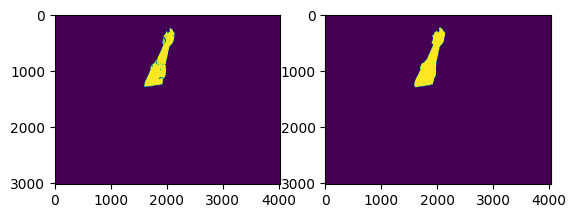

In [ ]:
plt.subplot(1,2,1)
plt.imshow(torch.nn.functional.interpolate(eval_results['shrilling chicken'][0].unsqueeze(1), size=eval_results[k][1].shape[-2:], mode='bilinear').squeeze()[0] > 0.5)
plt.subplot(1,2,2)
plt.imshow(eval_results['shrilling chicken'][1][0])

# Only Keep the "Whole" Layer Features and Masks (for 3D-OVS)

After extracting the masks and corresponding features with preprocess.py for 3D-OVS, we use this part of code to remove unwanted masks. To use this code, please modify the output path of preprocess.py from language_features to language_features_3dovs.

In [ ]:
def convert_langsplat_feature_mask_to_opengaussian(langsplat_f_path = ''):
    langsplat_f = np.load(langsplat_f_path)
    langsplat_s = np.load(langsplat_f_path[:-5] + 's.npy')
    final_layer_mask = langsplat_s[-1:]
    final_layer_mask = np.repeat(final_layer_mask, 4, axis = 0)
    print(np.unique(final_layer_mask))
    f = int(final_layer_mask[final_layer_mask > -1].min())
    t = int(final_layer_mask.max())

    final_layer_mask -= f
    final_layer_mask[final_layer_mask < 0] = -1

    new_features = langsplat_f[f: t+1]
    print(new_features.shape, langsplat_f.shape)

    return final_layer_mask, new_features

In [ ]:
import os
import numpy as np

root = './data/3dovs/bed/'
for fname in os.listdir(os.path.join(root, 'language_features_3dovs')):
    if not fname.endswith('_f.npy'):
        continue
    m, f = convert_langsplat_feature_mask_to_opengaussian(os.path.join(root,'language_features_3dovs',fname))
    np.save(os.path.join(root,'language_features',fname[:-5] + 'f.npy'), f)
    np.save(os.path.join(root,'language_features',fname[:-5] + 's.npy'), m)

# sofa bench

[-1. 32. 33. 34. 35. 36.]
(5, 512) (37, 512)
[-1. 32. 33. 34. 35. 36. 37.]
(6, 512) (38, 512)
[-1. 37. 38. 39. 40. 41. 42.]
(6, 512) (43, 512)
[-1. 29. 30. 31. 32. 33.]
(5, 512) (34, 512)
[-1. 33. 34. 35. 36. 37. 38.]
(6, 512) (39, 512)
[-1. 42. 43. 44. 45. 46. 47.]
(6, 512) (48, 512)
[-1. 28. 29. 30.]
(3, 512) (31, 512)
[-1. 36. 37. 38. 39. 40.]
(5, 512) (41, 512)
[-1. 36. 37. 38. 39. 40.]
(5, 512) (41, 512)
[-1. 27. 28. 29. 30. 31.]
(5, 512) (32, 512)
[-1. 40. 41. 42. 43. 44. 45.]
(6, 512) (46, 512)
[-1. 41. 42. 43. 44. 45. 46.]
(6, 512) (47, 512)
[-1. 35. 36. 37. 38. 39. 40.]
(6, 512) (41, 512)
[-1. 40. 41. 42. 43. 44. 45.]
(6, 512) (46, 512)
[-1. 44. 45. 46. 47. 48. 49.]
(6, 512) (50, 512)
[-1. 27. 28. 29. 30. 31.]
(5, 512) (32, 512)
[-1. 38. 39. 40. 41. 42. 43.]
(6, 512) (44, 512)
[-1. 47. 48. 49. 50. 51. 52.]
(6, 512) (53, 512)
[-1. 29. 30. 31. 32. 33. 34.]
(6, 512) (35, 512)
[-1. 38. 39. 40. 41. 42.]
(5, 512) (43, 512)
[-1. 38. 39. 40. 41. 42. 43.]
(6, 512) (44, 512)
[-1. 44. 45